# PINN 1D-BURGERS MORZARIA KERAS-TUNER TF2 - 04

*2024-06-25*

- BayesianOptimization Tuner. <https://keras.io/api/keras_tuner/tuners/bayesian/>
- For this implementation it was chosen that the objective function used in Keras Tuner is the loss function itself.
- It would be interesting to create an implementation where the objective function is a comparison (L2) with the exact data dataset.
- This code, despite working, is full of garbage and needs to be rewritten and documented.

References:

- Introduction to the Keras Tuner. <https://www.tensorflow.org/tutorials/keras/keras_tuner>
- Keras Tuner. <https://keras.io/guides/keras_tuner/getting_started>
- L-BFGS algorithm. <https://www.tensorflow.org/probability/api_docs/python/tfp/optimizer/lbfgs_minimize>
- Deep Morzaria (2020). <https://github.com/deepmorzaria/Physics-Informed-Neural-Network-PINNs---TF-2.0>
- Pi-Yueh Chuang (2020). <https://gist.github.com/piyueh/712ec7d4540489aad2dcfb80f9a54993>

In [1]:
%env TF_CPP_MIN_LOG_LEVEL=3
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import callbacks, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Flatten
import keras_tuner as kt
from scipy.io import loadmat
import matplotlib as mpl
from matplotlib import pyplot, cm
from pyDOE import lhs
import pandas as pd
import numpy as np
import tensorflow_probability as tfp

tf.keras.backend.set_floatx("float64")

env: TF_CPP_MIN_LOG_LEVEL=3


In [2]:
DATA_DIR = "../data/"
NO_MAX_INTE = 100  # 1000
NO_OF_INTE_POIN = 8000  # 8000
NO_OF_COLL_POIN = 100  # 100

In [3]:
# These contain data for the actual output of PDE at t=0.25,0.50,0.75
# which would later used to compare with the predicted output of neural
# network
actual_outputs_1 = pd.read_excel(DATA_DIR + r"t=0.25.xlsx")
actual_outputs_2 = pd.read_excel(DATA_DIR + r"t=0.50.xlsx")
actual_outputs_3 = pd.read_excel(DATA_DIR + r"t=0.75.xlsx")

In [4]:
data = loadmat(DATA_DIR + "burgers_shock.mat")

In [5]:
# Extracting input and outputs from data
x = data["x"]  # (256,1)      x varies from [-1,1]
t = data["t"]  # (100,1)      t varies from [0,1]
Exact = data["usol"].T  # (100,256)

In [6]:
X, T = np.meshgrid(x, t)  # X-(100,256)  T-(100,256)
# flatten() will return a list of numbers. [:,None] converts it to
# list of list. Refer to numpy.hstack syntax for more details.
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]

# X_star (25600,2) Set of points for each time instant
# u_star (25600,1) ouputs for each (x,t)

In [7]:
# data for initial boundary condition   (256,2)
xx1 = np.hstack((X[0:1, :].T, T[0:1, :].T))
# data for boundary condition for x=-1  (100,2)
xx2 = np.hstack((X[:, 0:1], T[:, 0:1]))
# data for boundary condition for x=1   (100,2)
xx3 = np.hstack((X[:, -1:], T[:, -1:]))

uu1 = Exact[0:1, :].T
uu2 = Exact[:, 0:1]
uu3 = Exact[:, -1:]

In [8]:
lb = X_star.min(axis=0)  # (1,2)   [-1 0]
ub = X_star.max(axis=0)  # (1,2)   [1 0.99]


# (456,2) stacking up all data related to bc's
X_u_train_ds = np.vstack([xx1, xx2, xx3])

# (8000,2) lhs is used to generate random sample of points.
# 2 is no of variables(x,t).
X_f_train = lb + (ub - lb) * lhs(2, NO_OF_INTE_POIN)

# (NO_OF_INTE_POIN + 456,2)
X_f_train = np.vstack((X_f_train, X_u_train_ds))

# (456,1) correspoing to X_u_train_ds
u_train_ds = np.vstack([uu1, uu2, uu3])

In [9]:
# random sample of collocation points from 456 numbers
idx = np.random.choice(
    X_u_train_ds.shape[0], NO_OF_COLL_POIN, replace=False
)

# Those collocation points chosen from boundary conditions data
X_u_train = X_u_train_ds[idx, :]

# Output corresponding to collocation points
u_train = u_train_ds[idx, :]

In [10]:
X_u_train.shape, X_u_train_ds.shape

((100, 2), (456, 2))

In [11]:
u_train.shape, u_train_ds.shape

((100, 1), (456, 1))

In [12]:
x_val = X_u_train_ds[-100:]
u_val = u_train_ds[-100:]

In [13]:
x_val.shape, u_val.shape

((100, 2), (100, 1))

In [14]:
# subscript u denotes collocation/boundary points and
# subscript f denotes interior points
x_u = X_u_train[:, 0:1]  # Separating x,t from X_u_train
t_u = X_u_train[:, 1:2]
x_f = X_f_train[:, 0:1]
t_f = X_f_train[:, 1:2]

In [15]:
# Converting to tensor varialble. Essential for calculating
# gradients later on.
x_u_tf = tf.Variable(x_u)
t_u_tf = tf.Variable(t_u)
x_f_tf = tf.Variable(x_f)
t_f_tf = tf.Variable(t_f)
X_f_train_tf = tf.Variable(X_f_train)

In [16]:
# function for calculating loss wrt to interior points
def interior_loss(model):
    
    with tf.GradientTape() as tape:
        tape.watch(X_f_train_tf)
        with tf.GradientTape() as tape2:
            u_predicted = model(X_f_train_tf)
        grad = tape2.gradient(u_predicted, X_f_train_tf)
        du_dx = grad[:, 0]
        du_dt = grad[:, 1]
    j = tape.gradient(grad, X_f_train_tf)
    d2u_dx2 = j[:, 0]

    u_predicted = tf.cast(u_predicted, dtype=tf.float64)
    du_dx = tf.reshape(du_dx, [NO_OF_INTE_POIN + 456, 1])
    d2u_dx2 = tf.reshape(d2u_dx2, [NO_OF_INTE_POIN + 456, 1])
    du_dt = tf.reshape(du_dt, [NO_OF_INTE_POIN + 456, 1])

    f = du_dt + u_predicted * du_dx - (0.01 / 3.14 * d2u_dx2)
    f = tf.math.reduce_mean(tf.math.square(f))

    return f

LBFG-S, which is second order optimizer, has been used to update the weights and biases because conventional first order optimizers Adam, Gradient descent and RMSprop 
are slow to converge.LBFG-S is not available by default in Tensorflow 2.0 and hence a function from Tensorflow Probability has been used. This has not been coded by me
except for a minor addition to loss function(check the loss_value variable). Please refer to the link below to get a better idea.

<https://gist.github.com/piyueh/712ec7d4540489aad2dcfb80f9a54993>

In [17]:
def function_factory(model, loss, train_x, train_y):
    """A factory to create a function required by tfp.optimizer.lbfgs_minimize.
    Args:
        model [in]: an instance of `tf.keras.Model` or its subclasses.
        loss [in]: a function with signature loss_value = loss(pred_y, true_y).
        train_x [in]: the input part of training data.
        train_y [in]: the output part of training data.
    Returns:
        A function that has a signature of:
            loss_value, gradients = f(model_parameters).
    """

    # obtain the shapes of all trainable parameters in the model
    shapes = tf.shape_n(model.trainable_variables)
    n_tensors = len(shapes)

    # we'll use tf.dynamic_stitch and tf.dynamic_partition later,
    # so we need to prepare required information first
    count = 0
    idx = []  # stitch indices
    part = []  # partition indices

    for i, shape in enumerate(shapes):
        n = np.prod(shape)
        idx.append(
            tf.reshape(
                tf.range(count, count + n, dtype=tf.int32), shape
            )
        )
        part.extend([i] * n)
        count += n

    part = tf.constant(part)

    # =======================================
    @tf.function
    def assign_new_model_parameters(params_1d):
        """A function updating the model's parameters with a 1D tf.Tensor.
        Args:
            params_1d [in]: a 1D tf.Tensor representing the model's trainable parameters.
        """
        params = tf.dynamic_partition(params_1d, part, n_tensors)
        for i, (shape, param) in enumerate(zip(shapes, params)):
            model.trainable_variables[i].assign(
                tf.reshape(param, shape)
            )
        return
        # ---------------------------------------

    # =======================================
    # create a function that will be returned by this factory
    @tf.function
    def f(params_1d):
        """A function that can be used by tfp.optimizer.lbfgs_minimize.
        This function is created by function_factory.
        Args:
           params_1d [in]: a 1D tf.Tensor.
        Returns:
            A scalar loss and the gradients w.r.t. the `params_1d`.
        """

        # use GradientTape so that we can calculate the gradient of loss w.r.t. parameters
        with tf.GradientTape() as tape:
            # update the parameters in the model
            assign_new_model_parameters(params_1d)
            # calculate the loss
            loss_value = loss(model(train_x, training=True), train_y)
            int_loss = interior_loss(model)
            loss_value = loss_value + int_loss

        # calculate gradients and convert to 1D tf.Tensor
        grads = tape.gradient(loss_value, model.trainable_variables)
        grads = tf.dynamic_stitch(idx, grads)

        # print out iteration & loss
        f.iter.assign_add(1)
        tf.print("Iter:", f.iter, "loss:", loss_value)

        # store loss value so we can retrieve later
        tf.py_function(f.history.append, inp=[loss_value], Tout=[])

        # training_path.append(model.get_weights())

        return loss_value, grads
        # ---------------------------------------

    # store these information as members so we can use them
    # outside the scope
    f.iter = tf.Variable(0)
    f.idx = idx
    f.part = part
    f.shapes = shapes
    f.assign_new_model_parameters = assign_new_model_parameters
    f.history = []

    return f

In [18]:
def KERAS_CODE(units, nlayers, activation):
    global model
    model = Sequential()
    # INPUT LAYER
    model.add(
        keras.Input(
            shape=(2,),
            name="InputLayer",
        )
    )
    
    # HIDDEN LAYERS
    for i in range(nlayers):
        model.add(
            Dense(
                units=units,
                activation=activation,
                name="Hidden" + str(i + 1),
            )
        )

    # OUTPUT LAYER
    model.add(
        Dense(
            units=1,
            activation=None,
            name="OutputLayer",
        )
    )

    funcfac = function_factory(
        model,
        tf.keras.losses.MeanSquaredError(),
        X_u_train,
        u_train,
    )

    init_params = tf.dynamic_stitch(
        funcfac.idx, model.trainable_variables
    )

    # TRAIN
    results = tfp.optimizer.lbfgs_minimize(
        value_and_gradients_function=funcfac,
        initial_position=init_params,
        max_iterations=NO_MAX_INTE,
        parallel_iterations=4,
    )

    funcfac.assign_new_model_parameters(results.position)

    return results.objective_value.numpy()

    kt.RandomSearch
    kt.Hyperband
    kt.BayesianOptimization

- Hyperband is not working, I couldn't figure out why.

In [19]:
# class MyTuner(kt.RandomSearch):
# class MyTuner(kt.Hyperband):
class MyTuner(kt.BayesianOptimization):    
    def run_trial(self, trial, **kwargs):
        hp = trial.hyperparameters
        return KERAS_CODE(
            units=hp.Int("units", 10, 30, 5),
            nlayers=hp.Int("nlayers", 2, 8, 2),
            activation=hp.Choice("activation", ["sigmoid", "relu", "tanh"]),
        )

    Defaults:
        executions_per_trial=1,
        max_trials=10,

In [20]:
tuner = MyTuner(
    max_trials=30,
    overwrite=True,
    directory="keras-tuner",
    project_name="test01",
)

In [21]:
tuner.search()

Trial 30 Complete [00h 00m 25s]
default_objective: 0.0810261998081245

Best default_objective So Far: 0.06662282992428806
Total elapsed time: 00h 16m 23s


In [22]:
tuner.results_summary(num_trials=2)

Results summary
Results in keras-tuner/test01
Showing 2 best trials
Objective(name="default_objective", direction="min")

Trial 26 summary
Hyperparameters:
units: 15
nlayers: 4
activation: tanh
Score: 0.06662282992428806

Trial 09 summary
Hyperparameters:
units: 15
nlayers: 6
activation: tanh
Score: 0.06713318781723907


---

Execution from this point forward only makes sense if retrained using the best model.

In [109]:
p = np.vstack([X_f_train, X_u_train])
q = np.vstack([model.predict(X_f_train), model.predict(X_u_train)])[
    :, 0
]

74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [110]:
def plot_helper(inputs, outputs, title):
    pyplot.figure(figsize=(8, 4))
    pyplot.tricontourf(
        inputs[:, 1], inputs[:, 0], outputs.flatten(), 100
    )
    pyplot.scatter(
        X_u_train[:, 1], X_u_train[:, 0], marker="x", s=100, c="k"
    )
    pyplot.xlabel("t")
    pyplot.ylabel("x")
    pyplot.title(title)
    pyplot.colorbar()

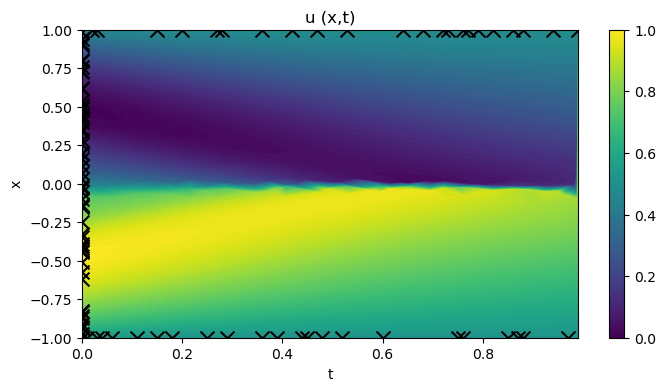

In [111]:
plot_helper(p, q, "u (x,t)")

In [26]:
x_t_25 = np.hstack((X[0:1, :].T, T[25:26, :].T))
x_t_50 = np.hstack((X[0:1, :].T, T[50:51, :].T))
x_t_75 = np.hstack((X[0:1, :].T, T[75:76, :].T))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


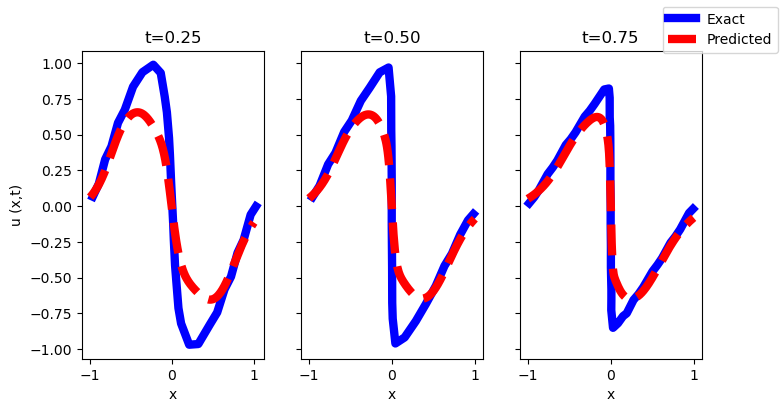

In [27]:
fig, axs = pyplot.subplots(1, 3, figsize=(8, 4), sharey=True)
(l1,) = axs[0].plot(
    actual_outputs_1["x"], actual_outputs_1["t"], linewidth=6, color="b"
)
(l2,) = axs[0].plot(
    x_t_25[:, 0],
    model.predict(x_t_25),
    linewidth=6,
    linestyle="dashed",
    color="r",
)
axs[0].set_title("t=0.25")
axs[0].set_xlabel("x")
axs[0].set_ylabel("u (x,t)")

axs[1].plot(
    actual_outputs_2["x"], actual_outputs_2["t"], linewidth=6, color="b"
)
axs[1].plot(
    x_t_50[:, 0],
    model.predict(x_t_50),
    linewidth=6,
    linestyle="dashed",
    color="r",
)
axs[1].set_title("t=0.50")
axs[1].set_xlabel("x")

axs[2].plot(
    actual_outputs_3["x"], actual_outputs_3["t"], linewidth=6, color="b"
)
axs[2].plot(
    x_t_75[:, 0],
    model.predict(x_t_75),
    linewidth=6,
    linestyle="dashed",
    color="r",
)
axs[2].set_title("t=0.75")
axs[2].set_xlabel("x")

# line_labels = ['Exact','Predicted']

fig.legend(
    handles=(l1, l2), labels=("Exact", "Predicted"), loc="upper right"
)
# pyplot.savefig('graphs3.pdf')

In [28]:
r = model.predict(X_u_train)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [29]:
error_u = np.linalg.norm(u_train - r, 2) / np.linalg.norm(u_star, 2)
print(error_u)

0.01959333104689958


In [87]:
print(tf.__version__)

2.16.1
